### Prodigy ML Task 3 ###
Implement a support vector machine (SVM) to classify images of cats and dogs from the Kaggle dataset.

Loading and visualizing images...


Loading images from C:\Study Material\Iternship\Prodigy\Task 3\dogs-vs-cats\train\train: 100%|██████████| 20/20 [00:00<00:00, 493.48it/s]


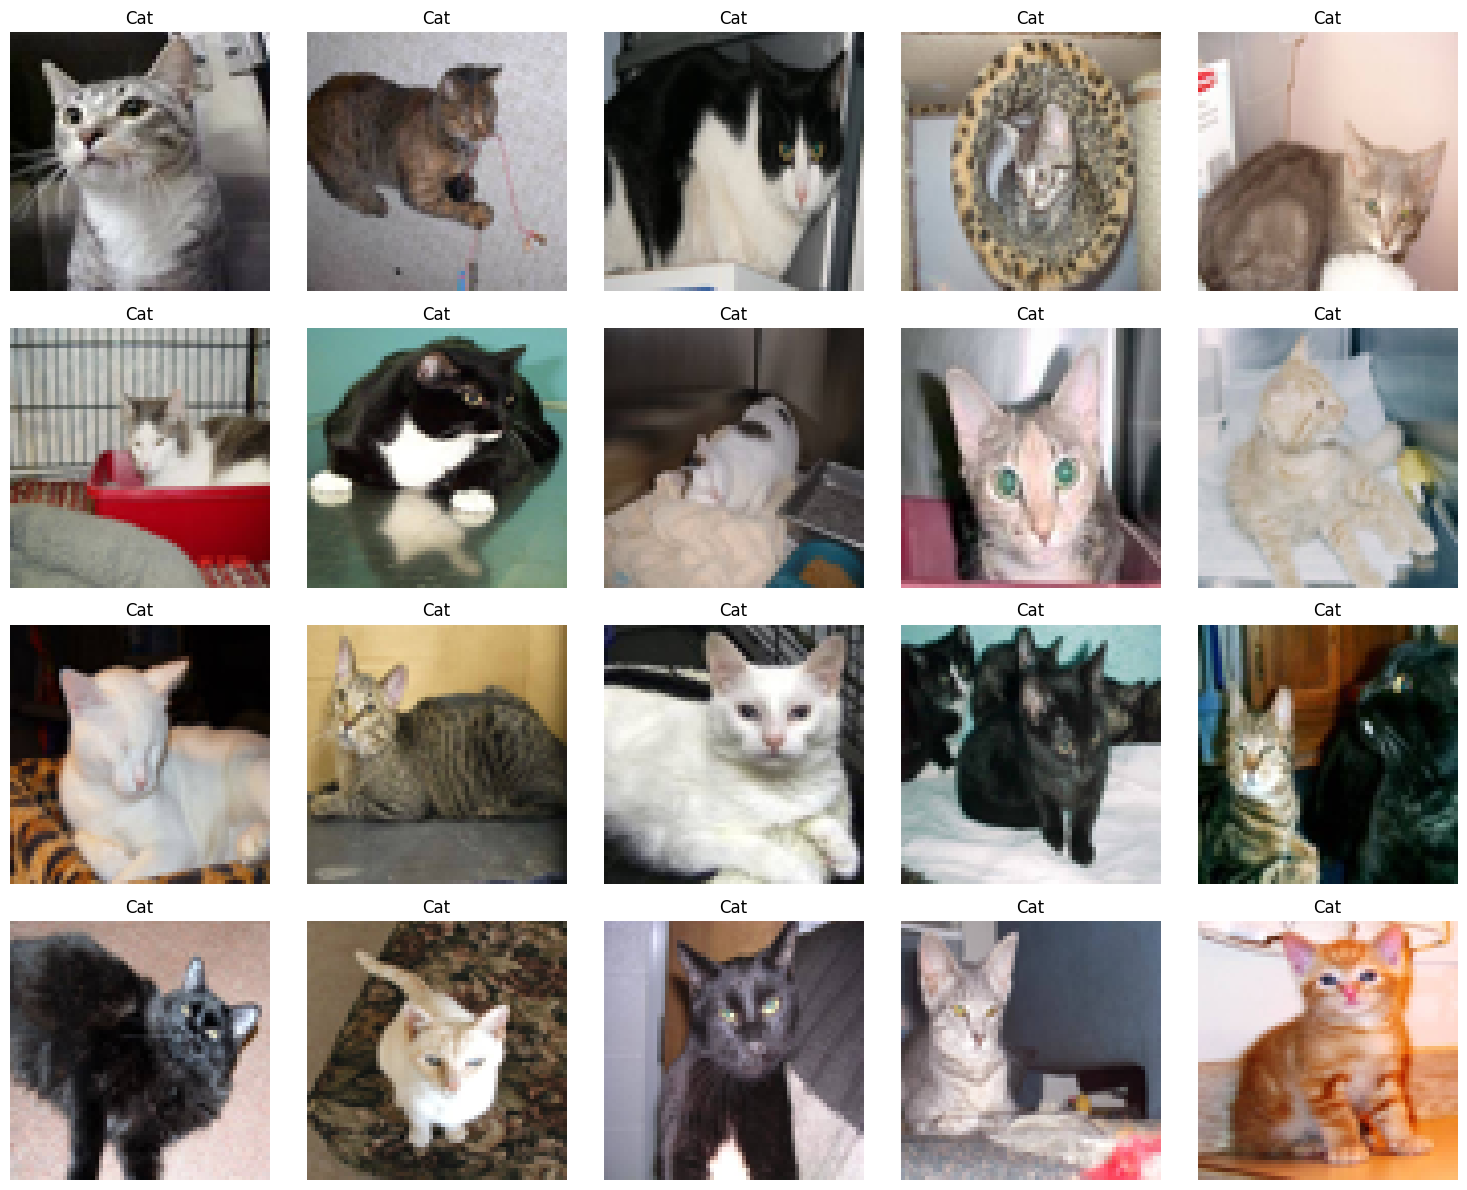

Loading images from C:\Study Material\Iternship\Prodigy\Task 3\dogs-vs-cats\train\train: 100%|██████████| 20/20 [00:00<00:00, 606.04it/s]


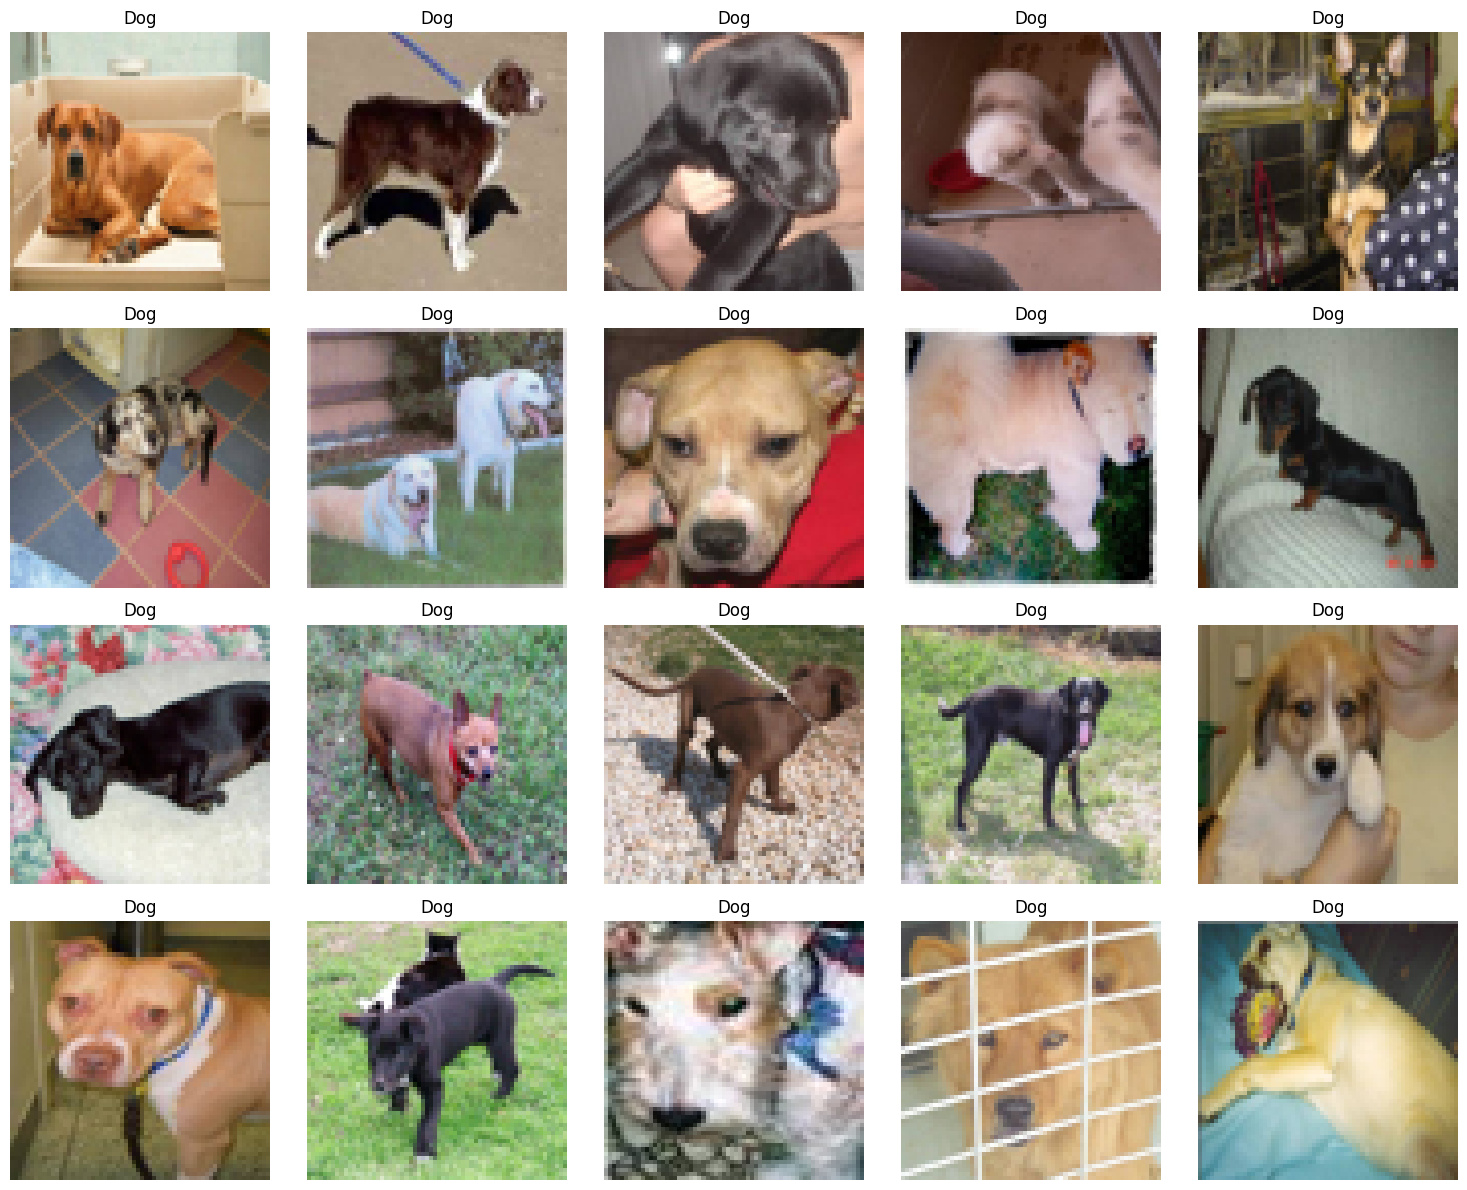

Loading images from C:\Study Material\Iternship\Prodigy\Task 3\dogs-vs-cats\train\train: 100%|██████████| 20/20 [00:00<00:00, 579.40it/s]


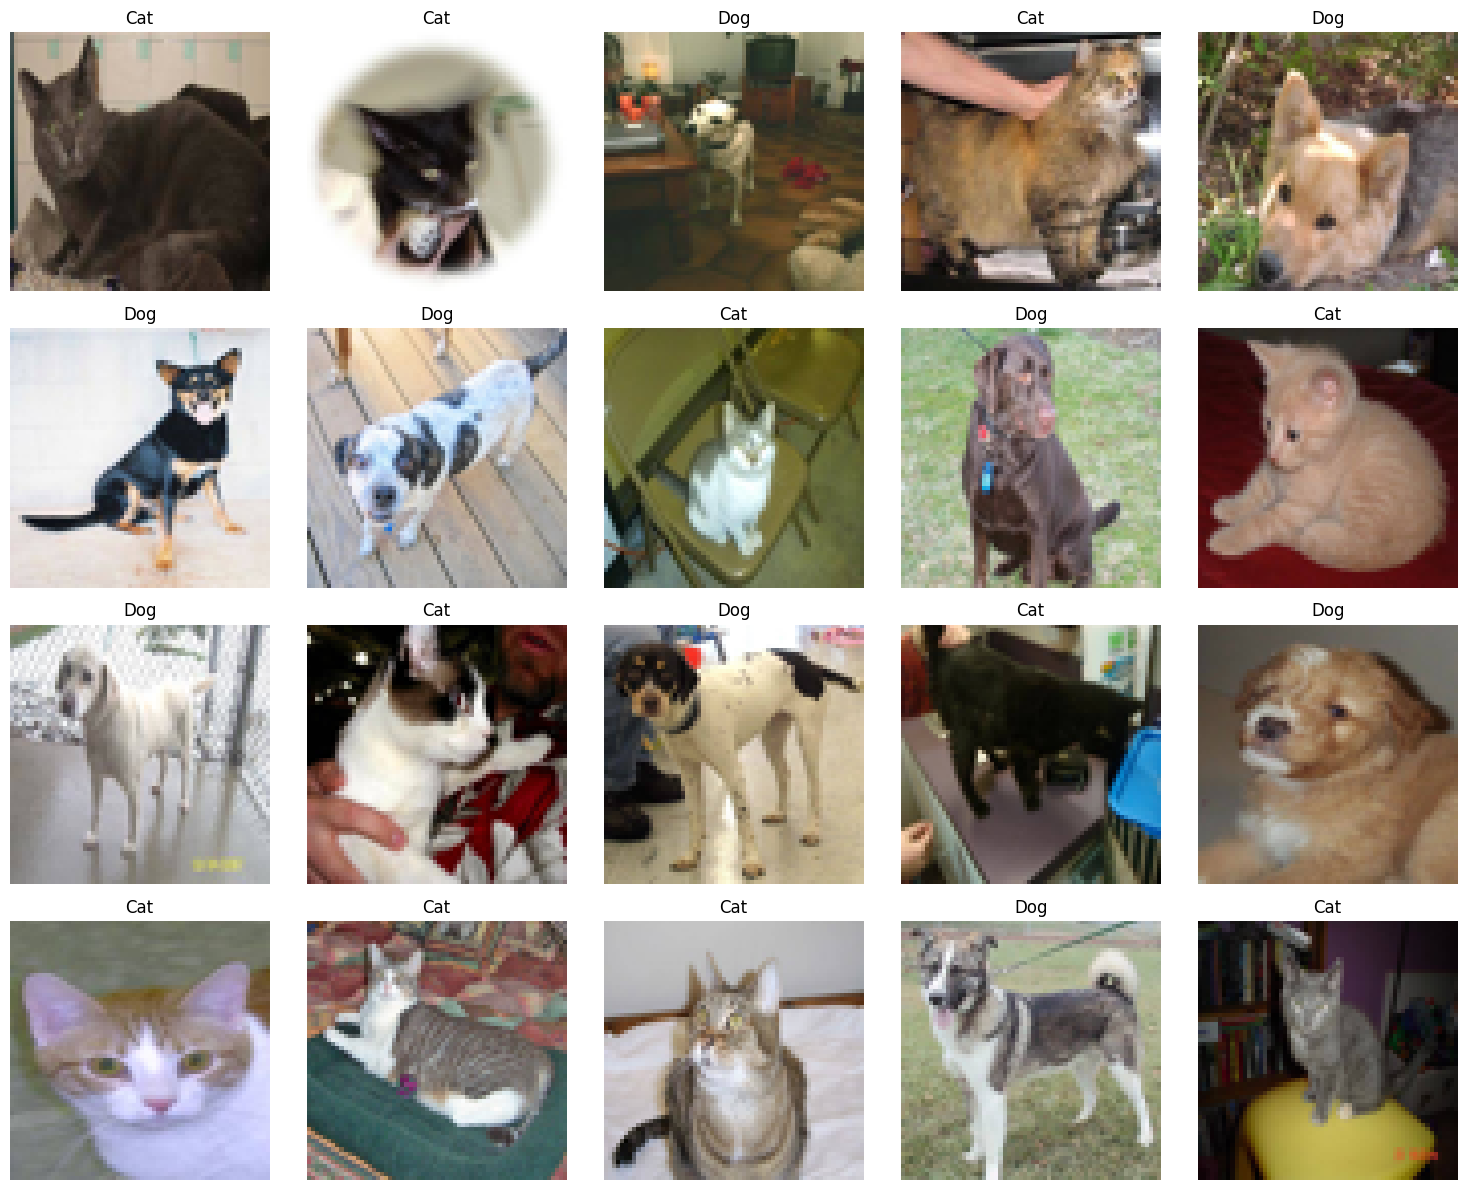

Loading full dataset...


Loading images from C:\Study Material\Iternship\Prodigy\Task 3\dogs-vs-cats\train\train: 100%|██████████| 25000/25000 [00:39<00:00, 636.04it/s]


Loaded 25,000 images in 40.28 seconds. Current memory usage: 2570.01 MB
Shape of images array: (25000, 64, 64, 3)
Scaling data...
Data scaled. Current memory usage: 4914.92 MB
Applying PCA to reduce dimensionality...
Shape of reduced data: (25000, 570)
Splitting reduced data into training and validation sets...
Data split completed. Current memory usage: 3641.18 MB
Training SVM model on reduced dataset...
Training completed in 143.67 seconds. Current memory usage: 3719.24 MB
Validating the model...
Validation Accuracy: 0.6866
Validation Classification Report:
              precision    recall  f1-score   support

         Cat       0.68      0.69      0.68      2459
         Dog       0.69      0.68      0.69      2541

    accuracy                           0.69      5000
   macro avg       0.69      0.69      0.69      5000
weighted avg       0.69      0.69      0.69      5000

Validation Confusion Matrix:


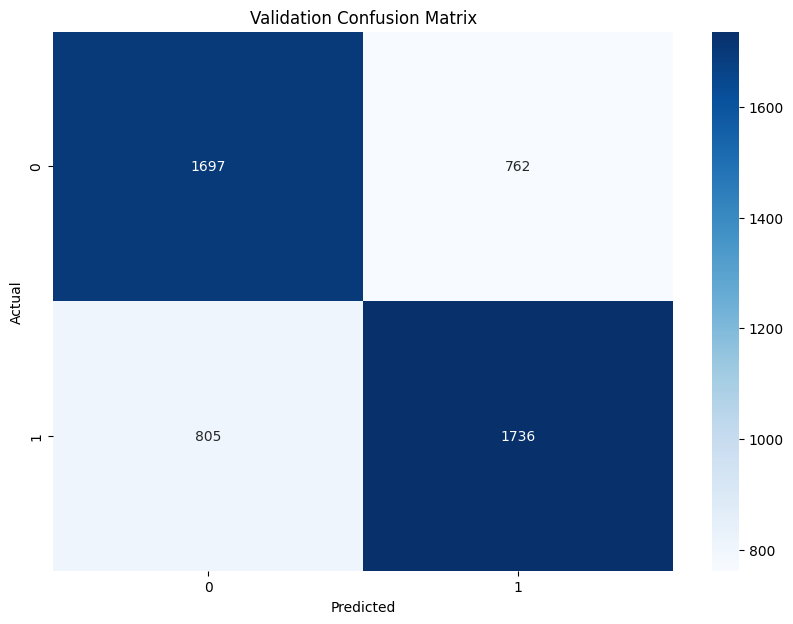

Loading and processing test data...


Loading images from C:\Study Material\Iternship\Prodigy\Task 3\dogs-vs-cats\test1\test1: 100%|██████████| 12500/12500 [00:29<00:00, 428.91it/s]


Test data processed. Current memory usage: 6088.52 MB
Testing the model on unseen data...
Testing completed in 80.04 seconds. Current memory usage: 6157.39 MB


Entire process completed. Total memory usage: 6282.00 MB


In [1]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from PIL import Image
import plotly.express as px
import time
import pickle
import seaborn as sns
import pandas as pd
import psutil  # To monitor memory usage

# Paths for training and test data
train_dir = r'C:\Study Material\Iternship\Prodigy\Task 3\dogs-vs-cats\train\train'
test_dir = r'C:\Study Material\Iternship\Prodigy\Task 3\dogs-vs-cats\test1\test1'

# Function to monitor memory usage
def memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # Convert bytes to MB

def load_images(folder, img_size=(64, 64), sample_count=None, label_filter=None):
    images = []
    labels = []
    filenames = os.listdir(folder)
    
    if label_filter is not None:
        filenames = [fname for fname in filenames if label_filter in fname]
    
    if sample_count:
        random.shuffle(filenames)
        filenames = filenames[:sample_count]
    
    for img in tqdm(filenames, desc=f"Loading images from {folder}"):
        try:
            img_path = os.path.join(folder, img)
            img_pil = Image.open(img_path)
            img_pil = img_pil.resize(img_size)
            img_np = np.array(img_pil) / 255.0  # Normalize pixel values
            images.append(img_np)
            labels.append(0 if 'cat' in img else 1)
        except Exception as e:
            print(f"Error loading image {img}: {e}")
    
    return np.array(images), np.array(labels)

def visualize_images(images, labels, sample_count=20):
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()
    
    for i in range(sample_count):
        axes[i].imshow(images[i])
        axes[i].set_title('Cat' if labels[i] == 0 else 'Dog')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_tsne_data(tsne_data, labels, title):
    df_tsne = pd.DataFrame()
    df_tsne['X'] = tsne_data[:, 0]
    df_tsne['Y'] = tsne_data[:, 1]
    df_tsne['Label'] = labels
    df_tsne['Label'] = df_tsne['Label'].map({0: 'Cat', 1: 'Dog'})
    
    fig = px.scatter(df_tsne, x='X', y='Y', color='Label', title=title)
    fig.show()

# Load and visualize images
print("Loading and visualizing images...")
cat_images, cat_labels = load_images(train_dir, sample_count=20, label_filter='cat')
visualize_images(cat_images, cat_labels, sample_count=20)

dog_images, dog_labels = load_images(train_dir, sample_count=20, label_filter='dog')
visualize_images(dog_images, dog_labels, sample_count=20)

all_images, all_labels = load_images(train_dir, sample_count=20)
visualize_images(all_images, all_labels, sample_count=20)

# Load a larger set of images for training
print("Loading full dataset...")
start_time = time.time()
images, labels = load_images(train_dir, sample_count=25000)
loading_time = time.time() - start_time
print(f"Loaded 25,000 images in {loading_time:.2f} seconds. Current memory usage: {memory_usage():.2f} MB")
images = images / 255.0

print("Shape of images array:", images.shape)
n_samples, img_height, img_width, img_channels = images.shape

# Flatten images
images_flat = images.reshape(n_samples, -1)

# Scale data
print("Scaling data...")
scaler = StandardScaler()
images_flat_scaled = scaler.fit_transform(images_flat)
print(f"Data scaled. Current memory usage: {memory_usage():.2f} MB")

# Apply PCA to reduce dimensionality
print("Applying PCA to reduce dimensionality...")
pca = PCA(n_components=0.95)  # Retain 95% of the variance
reduced_images_pca = pca.fit_transform(images_flat_scaled)
print(f"Shape of reduced data: {reduced_images_pca.shape}")

# Split the reduced data into training and validation sets
print("Splitting reduced data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(reduced_images_pca, labels, test_size=0.2, random_state=42)
print(f"Data split completed. Current memory usage: {memory_usage():.2f} MB")

# Train the SVM model on the reduced dataset
print("Training SVM model on reduced dataset...")
start_time = time.time()
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds. Current memory usage: {memory_usage():.2f} MB")

# Validate the model
print("Validating the model...")
y_val_pred = svm.predict(X_val)

# Calculate validation accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
val_class_report = classification_report(y_val, y_val_pred, target_names=['Cat', 'Dog'])
val_conf_matrix = confusion_matrix(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print('Validation Classification Report:')
print(val_class_report)

# Plot confusion matrix
print('Validation Confusion Matrix:')
plt.figure(figsize=(10, 7))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()

# Save the model and scaler
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

# Load and process test data
print("Loading and processing test data...")
test_images, test_labels = load_images(test_dir, sample_count=12500)
test_images = test_images / 255.0

# Flatten and scale test images
n_test_samples, test_img_height, test_img_width, test_img_channels = test_images.shape
test_images_flat = test_images.reshape(n_test_samples, -1)
test_images_flat_scaled = scaler.transform(test_images_flat)
print(f"Test data processed. Current memory usage: {memory_usage():.2f} MB")

# Apply PCA to test data
test_images_pca = pca.transform(test_images_flat_scaled)

# Test the model
print("Testing the model on unseen data...")
start_time = time.time()
y_test_pred = svm.predict(test_images_pca)
testing_time = time.time() - start_time
print(f"Testing completed in {testing_time:.2f} seconds. Current memory usage: {memory_usage():.2f} MB")

# Visualize test results
test_perplexity = min(30, n_test_samples - 1)
test_tsne = TSNE(n_components=2, perplexity=test_perplexity, random_state=42)
test_images_tsne = test_tsne.fit_transform(test_images_pca)
plot_tsne_data(test_images_tsne, y_test_pred, 't-SNE visualization of Test Data Predictions')

# Save predictions
test_predictions = pd.DataFrame({'Id': np.arange(1, n_test_samples + 1), 'Label': y_test_pred})
test_predictions['Label'] = test_predictions['Label'].map({0: 'Cat', 1: 'Dog'})
test_predictions.to_csv('test_predictions.csv', index=False)

print(f"Entire process completed. Total memory usage: {memory_usage():.2f} MB")
